In [2]:
%matplotlib inline

import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
# from imutils  import paths

# import opencv as cv

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

18.46599794238683


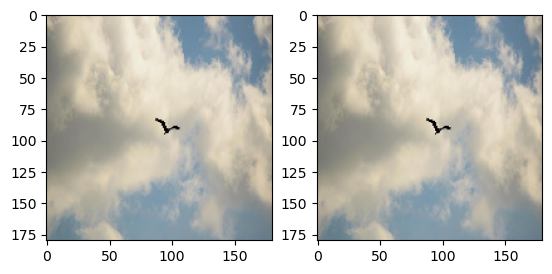

In [4]:
# img = cv2.imread(os.path.expanduser( "~/Projects/nn/nn_tf/BirdVsDrone/Birds/singleBirdinsky0.jpeg"))
img = cv2.imread("/Users/mantesssa/Projects/nn/nn_tf/BirdVsDrone/Birds/singleBirdinsky0.jpeg")
# imgs = cv2.imread("/Users/mantesssa/Projects/nn/nn_tf/BirdVsDrone/Birds/")

# print(os.path.expanduser( "~/Projects/nn/nn_tf/BirdVsDrone/Birds/singleBirdinsky0.jpeg"))
# /Users/mantesssa/Projects/nn/nn_tf/BirdVsDrone/Birds/singleBirdinsky0.jpeg
# img.

RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
smallimg = cv2.resize(RGB_img, (180,180)) 
smallimgb = cv2.resize(RGB_img, (180,180),interpolation=cv2.INTER_CUBIC) 


plt.subplot(1, 2, 1)
plt.imshow(smallimg)
plt.subplot(1, 2, 2)
plt.imshow(smallimgb)

print(np.mean(smallimg-smallimgb))
# imgs



# cv2.namedWindow("Images") # do not work
# cv2.imshow('Images',img)
# cv2.waitKey(1)
# cv2.destroyAllWindows()
# imagePath = list(paths.list_images("Projects/nn/nn_tf/BirdVsDrone/Birds"))

In [20]:
dirname = "/Users/mantesssa/Projects/nn/nn_tf/BirdVsDrone/"

tree = os.walk(dirname)

fulllist =[]
for i in tree:
    if i.name == '*/*.JPEG':
        print("lol")
    fulllist.append(i)
#     print(i)

listofdronesnames = fulllist[1][2]
listofdroneslabels = [0]*len(listofdronesnames)

listofbirdsnames = fulllist[2][2]
listofbirdslabels = [1]*len(listofbirdsnames)

print("length of listofdronesnames =",len(listofdronesnames))
print("length of listofbirdsnames =",len(listofbirdsnames))


# for address, dirs, files in os.walk('test'):
#     for name in files:
#         print(os.path.join(address, name))


AttributeError: 'tuple' object has no attribute 'name'

In [67]:
fulllistnames = listofdronesnames + listofbirdsnames
fulllistlabels = listofdroneslabels + listofbirdslabels

filenames = tf.constant(fulllistnames)
labels = tf.constant(fulllistlabels)
# fulllistlabels

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
# fulllistnames # len = 829


In [37]:
(ds_train, ds_test), ds_info = tfds.load(
# (ds_train, ds_test)= tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2023-03-10 20:57:50.407628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Build a training pipeline

Apply the following transformations:

* `tf.data.Dataset.map`: TFDS provide images of type `tf.uint8`, while the model expects `tf.float32`. Therefore, you need to normalize images.
* `tf.data.Dataset.cache` As you fit the dataset in memory, cache it before shuffling for a better performance.<br/>
__Note:__ Random transformations should be applied after caching.
* `tf.data.Dataset.shuffle`: For true randomness, set the shuffle buffer to the full dataset size.<br/>
__Note:__ For large datasets that can't fit in memory, use `buffer_size=1000` if your system allows it.
* `tf.data.Dataset.batch`: Batch elements of the dataset after shuffling to get unique batches at each epoch.
* `tf.data.Dataset.prefetch`: It is good practice to end the pipeline by prefetching [for performance](https://www.tensorflow.org/guide/data_performance#prefetching).

In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255.0, label
#        tf.cast(x, dtype, name=None)

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)#???
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

### Build an evaluation pipeline

Your testing pipeline is similar to the training pipeline with small differences:

 * You don't need to call `tf.data.Dataset.shuffle`.
 * Caching is done after batching because batches can be the same between epochs.

In [6]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## Step 2: Create and train the model

Plug the TFDS input pipeline into a simple Keras model, compile the model, and train it.

In [18]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)), # 1st  input layer
  tf.keras.layers.Dense(128, activation='relu'), # 2 layer
#   tf.keras.layers.Dense(16, activation='relu'), # 3 layer
  tf.keras.layers.Dense(10) # 4 layer
    # dense layer = fully connected = полносвязный 
])


# Configures the model for training.
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# compile(
#     optimizer='rmsprop',
#     loss=None,
#     metrics=None,
#     loss_weights=None,
#     weighted_metrics=None,
#     run_eagerly=None,
#     steps_per_execution=None,
#     jit_compile=None,
#     **kwargs
# )


# Trains the model for a fixed number of epochs (iterations on a dataset).
# https://www.tensorflow.org/api_docs/python/tf/keras/Model
model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3538 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.1967 - val_sparse_categorical_accuracy: 0.9442
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1617 - sparse_categorical_accuracy: 0.9541 - val_loss: 0.1323 - val_sparse_categorical_accuracy: 0.9612
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.1168 - sparse_categorical_accuracy: 0.9668 - val_loss: 0.1148 - val_sparse_categorical_accuracy: 0.9656
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0896 - sparse_categorical_accuracy: 0.9745 - val_loss: 0.0934 - val_sparse_categorical_accuracy: 0.9711
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.0916 - val_sparse_categorical_accuracy: 0.9719
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0595 - sparse_categorica

In [ ]:
model.summary()

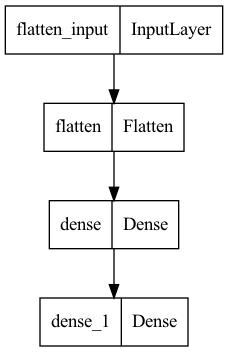

In [9]:
keras.utils.plot_model(model, "my_first_model.png")

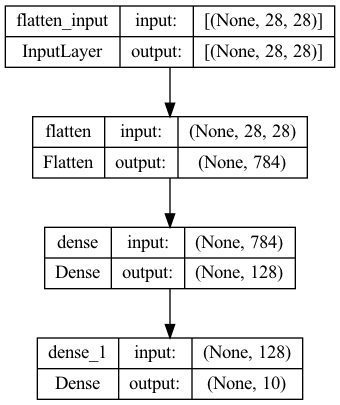

In [10]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)